Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
tesseract-ocr-fin is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
CSV already exists. Skipping image processing.

Monthly Spend Summary:
      date  Total Spend
0  2025-05       823.83

Top 5 Highest Spend Items Per Month:
      month                      item  price
24  2025-05   Ehrmann Maitorahka 0,2%  30.26
19  2025-05  Bellarom Crema kahvipavu  23.50
56  2025-05  Kot-Kot Vapaan kanan kan  22.14
87  2025-05  Milbona tilsiterviipalee  17.96
23  2025-05  Dunne mini San Marzano 6  15.77

Spending by Category for 2025-05:
  category   price
0    Dairy   77.80
1     Meat   31.61
2    Other  700.22
3   Snacks   14.20


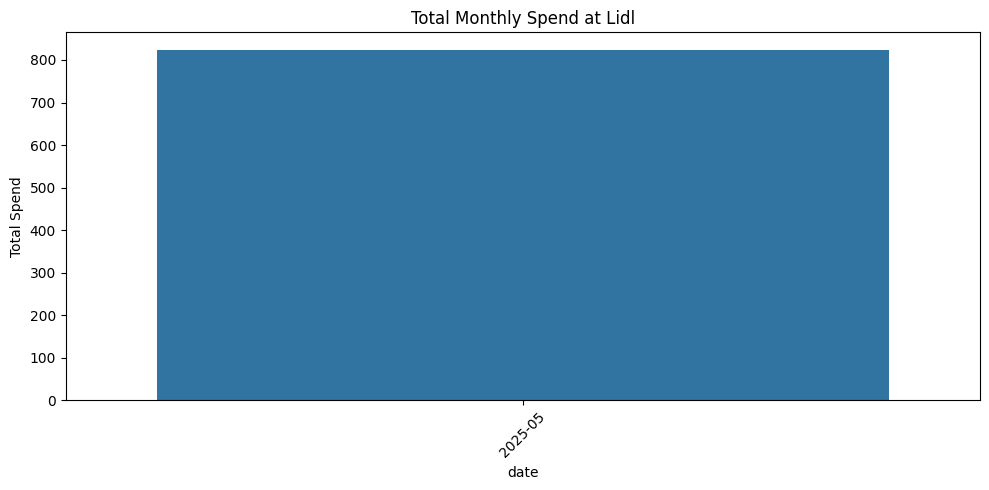

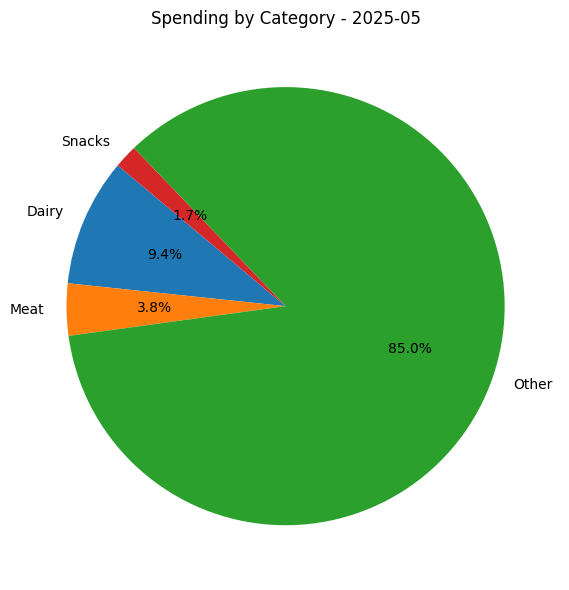

In [ ]:
# Lidl Receipt Analyzer - Google Colab Version

# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Install Tesseract OCR and Finnish language
!apt-get install -y tesseract-ocr tesseract-ocr-fin
!pip install pytesseract

# Step 3: Import libraries
import pytesseract
from PIL import Image
import pandas as pd
import re
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Step 4: Define category tagging function
def categorize(item_name):
    name = item_name.lower()
    if any(x in name for x in ['maito', 'juusto', 'rahka']):
        return 'Dairy'
    elif any(x in name for x in ['kana', 'liha', 'nakki']):
        return 'Meat'
    elif any(x in name for x in ['leipa', 'sämpylä']):
        return 'Bakery'
    elif any(x in name for x in ['mehu', 'vesi', 'limu']):
        return 'Drinks'
    elif any(x in name for x in ['suklaa', 'makea', 'donitsi']):
        return 'Snacks'
    return 'Other'

# Step 5: Define receipt parser (use filename date only)
def extract_receipt_data(image_path):
    filename = os.path.basename(image_path)
    fallback_date = None

    match_filename = re.match(r"(\d{4})\.(\d{2})\.(\d{2})", filename)
    if match_filename:
        try:
            fallback_date = f"{match_filename.group(1)}-{match_filename.group(2)}-{match_filename.group(3)}"
        except:
            fallback_date = None

    try:
        text = pytesseract.image_to_string(Image.open(image_path), lang='fin')
    except:
        text = pytesseract.image_to_string(Image.open(image_path))

    items = []
    for line in text.splitlines():
        match = re.match(r"(.+?)\s+([\d,]+)\s+[AB]?$", line.strip())
        if match:
            item, price = match.groups()
            try:
                price = float(price.replace(',', '.'))
                items.append({
                    'item': item.strip(),
                    'price': price,
                    'date': fallback_date
                })
            except:
                continue
    return items

# Step 6: Process all images in a folder, skip if CSV already exists
def process_receipts_folder(folder_path, csv_path):
    if os.path.exists(csv_path):
        print("CSV already exists. Skipping image processing.")
        return pd.read_csv(csv_path)

    all_data = []
    for file in os.listdir(folder_path):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepath = os.path.join(folder_path, file)
            print(f"Processing: {file}")
            receipt_items = extract_receipt_data(filepath)
            all_data.extend(receipt_items)
    df = pd.DataFrame(all_data)
    df['category'] = df['item'].apply(categorize)
    df.to_csv(csv_path, index=False)
    print(f"\nFull data saved to: {csv_path}")
    return df

# Step 7: Run the processor
folder_path = '/content/drive/MyDrive/LidlReceipts'
csv_path = '/content/drive/MyDrive/lidl_receipts_data.csv'
df = process_receipts_folder(folder_path, csv_path)

# Step 8: Clean and analyze
if not df.empty:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df.dropna(subset=['date'], inplace=True)
    df = df.sort_values('date')

    df['month'] = df['date'].dt.to_period('M').astype(str)
    df['category'] = df['item'].apply(categorize)

    monthly = df.groupby(df['date'].dt.to_period('M'))['price'].sum().reset_index(name='Total Spend')

    item_totals = df.groupby(['month', 'item'])['price'].sum().reset_index()
    top_expensive_by_month = item_totals.sort_values(['month', 'price'], ascending=[True, False]).groupby('month').head(5)

    latest_month = df['month'].max()
    latest_data = df[df['month'] == latest_month]
    category_summary = latest_data.groupby('category')['price'].sum().reset_index()

    print("\nMonthly Spend Summary:")
    print(monthly)

    print("\nTop 5 Highest Spend Items Per Month:")
    print(top_expensive_by_month[['month', 'item', 'price']])

    print(f"\nSpending by Category for {latest_month}:")
    print(category_summary)

    plt.figure(figsize=(10, 5))
    sns.barplot(data=monthly, x='date', y='Total Spend')
    plt.title('Total Monthly Spend at Lidl')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 6))
    plt.pie(category_summary['price'], labels=category_summary['category'], autopct='%1.1f%%', startangle=140)
    plt.title(f'Spending by Category - {latest_month}')
    plt.tight_layout()
    plt.show()

else:
    print("No valid receipt data found.")


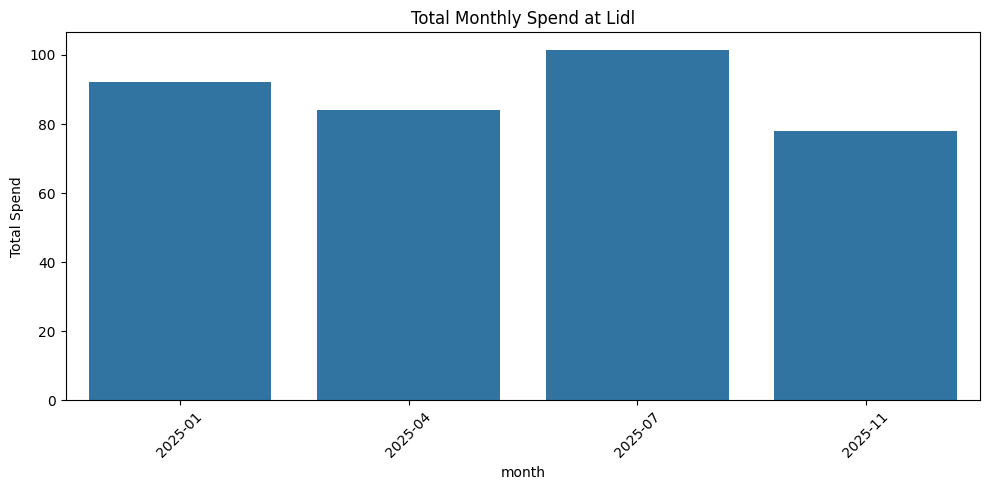

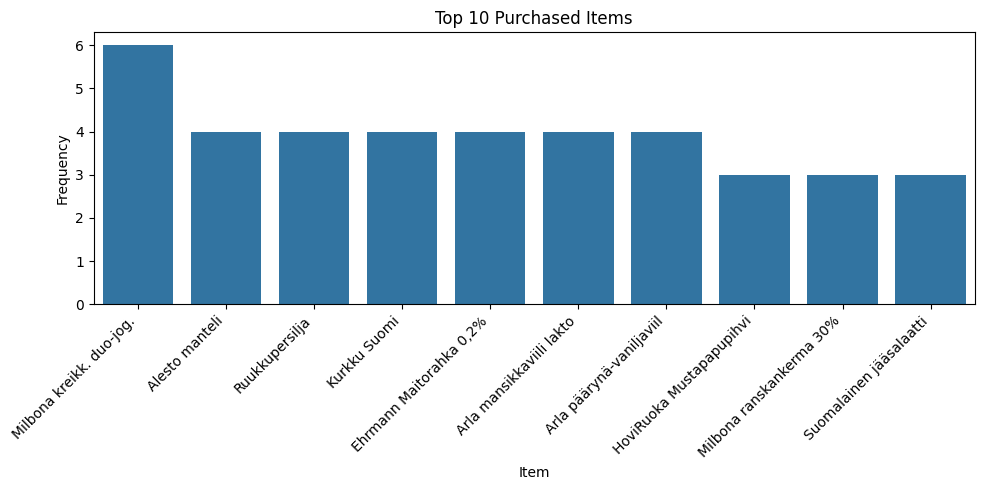

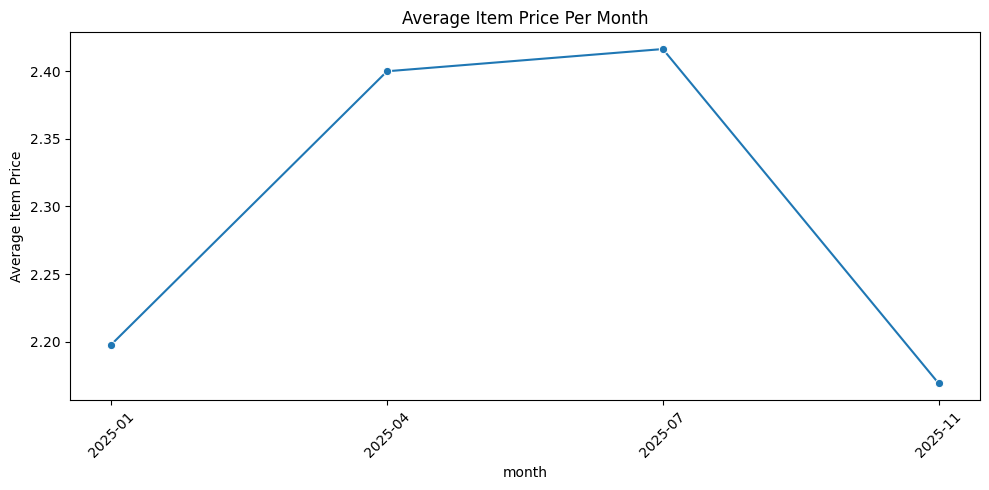

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load uploaded receipt data
csv_path = "/content/drive/MyDrive/lidl_receipts_data.csv"
df = pd.read_csv(csv_path)

# Ensure correct date format
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
df.dropna(subset=['date'], inplace=True)

# Add month column
df['month'] = df['date'].dt.to_period('M').astype(str)

# Total spend by month
monthly_totals = df.groupby('month')['price'].sum().reset_index(name='Total Spend')

# Top 10 items by frequency
top_items = df['item'].value_counts().head(10).reset_index()
top_items.columns = ['Item', 'Frequency']

# Average price per month
monthly_avg = df.groupby('month')['price'].mean().reset_index(name='Average Item Price')

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_totals, x='month', y='Total Spend')
plt.title('Total Monthly Spend at Lidl')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.barplot(data=top_items, x='Item', y='Frequency')
plt.title('Top 10 Purchased Items')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_avg, x='month', y='Average Item Price', marker='o')
plt.title('Average Item Price Per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


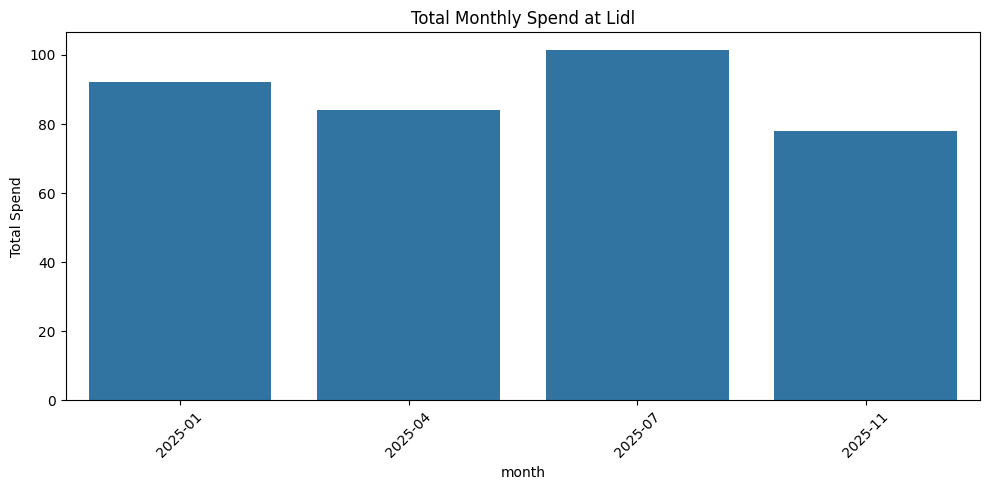

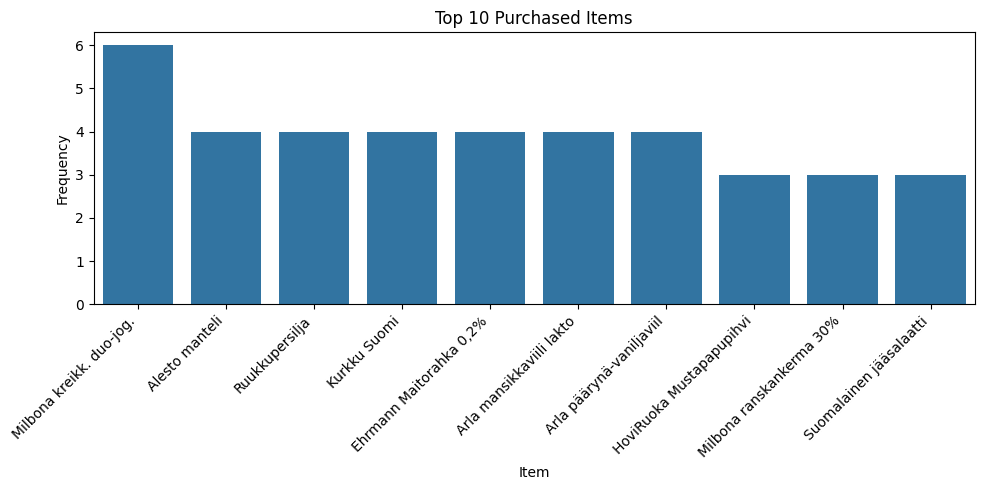

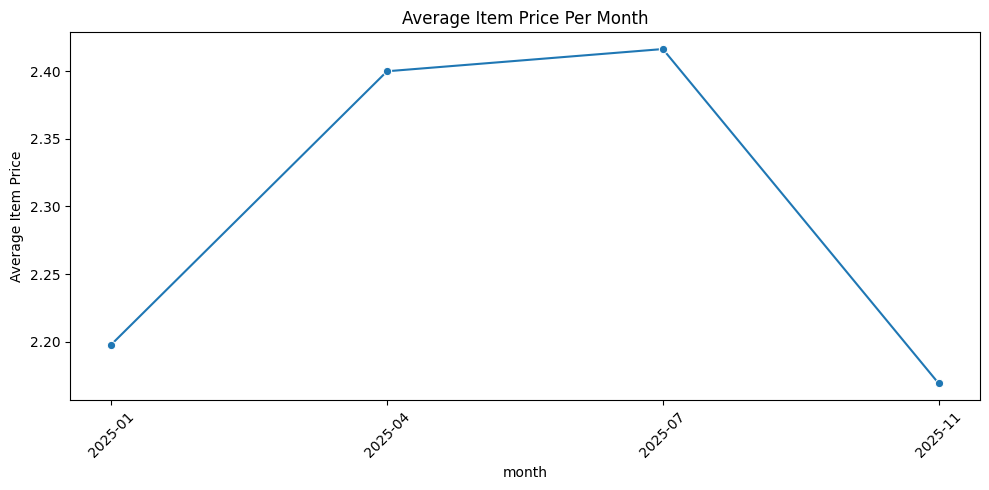

In [ ]:
# Re-importing and re-running after code execution state reset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reload the uploaded receipt data
csv_path = "/content/drive/MyDrive/lidl_receipts_data.csv"
df = pd.read_csv(csv_path)

# Parse and clean date column
df['date'] = pd.to_datetime(df['date'], errors='coerce', dayfirst=True)
df.dropna(subset=['date'], inplace=True)

# Add month for grouping
df['month'] = df['date'].dt.to_period('M').astype(str)

# Total spend by month
monthly_totals = df.groupby('month')['price'].sum().reset_index(name='Total Spend')

# Top 10 items by frequency
top_items = df['item'].value_counts().head(10).reset_index()
top_items.columns = ['Item', 'Frequency']

# Average item price by month
monthly_avg = df.groupby('month')['price'].mean().reset_index(name='Average Item Price')

# Plot: Total Monthly Spend
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_totals, x='month', y='Total Spend')
plt.title('Total Monthly Spend at Lidl')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot: Top 10 Purchased Items
plt.figure(figsize=(10, 5))
sns.barplot(data=top_items, x='Item', y='Frequency')
plt.title('Top 10 Purchased Items')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot: Average Item Price per Month
plt.figure(figsize=(10, 5))
sns.lineplot(data=monthly_avg, x='month', y='Average Item Price', marker='o')
plt.title('Average Item Price Per Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
